## ud120 final project
### Task 1: select features

In [4]:
#!/usr/bin/python

import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data, load_classifier_and_data, test_classifier


### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi'] # You will need to use more features

financial_features = ['salary', 'bonus', 'deferral_payments', 'total_payments', 
                      'loan_advances', 'restricted_stock_deferred', 
                      'deferred_income', 'total_stock_value', 'expenses', 
                      'exercised_stock_options', 'other', 
                      'long_term_incentive', 'restricted_stock',
                      'director_fees'] 

email_features = ['to_messages', 'email_address', 'from_poi_to_this_person', 
                  'from_messages', 'from_this_person_to_poi', 
                  'shared_receipt_with_poi']


### Load the dictionary containing the dataset
# try final_project_dataset.pkl if it doesn't work
with open("final_project_dataset_unix.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)


### Task 2: removing outliers

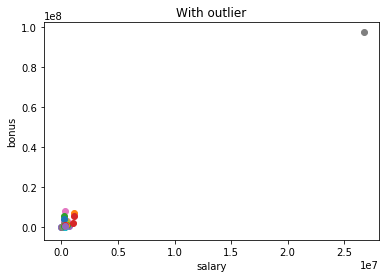

In [6]:
#%%
### Task 2: Remove outliers
import matplotlib.pyplot
%matplotlib inline  

def printFeatures(data, features, title):
    for point in data:
        matplotlib.pyplot.scatter( point[1], point[2] )
    matplotlib.pyplot.title(title)
    matplotlib.pyplot.xlabel(features[1])
    matplotlib.pyplot.ylabel(features[2])
    matplotlib.pyplot.show()

plotfeatures = ['poi', 'salary', 'bonus']
data = featureFormat(data_dict, features=plotfeatures)
printFeatures(data, plotfeatures, "With outlier")


The rows listed below don't have meaningful values. TOTAL and TRAVEL AGENCY aren't people.

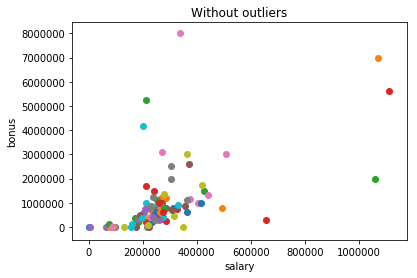

In [7]:
data_dict.pop("TOTAL", 0)
data_dict.pop("THE TRAVEL AGENCY IN THE PARK", 0)
data = featureFormat(data_dict, features=plotfeatures)
printFeatures(data, plotfeatures, "Without outliers")


### Task 3: create new features
new features taken from udacity forum [link](https://discussions.udacity.com/t/final-project-issues/249507)

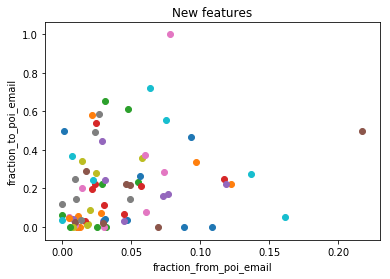

In [8]:
#%%
### Task 3: Create new feature(s)
### Store to my_dataset for easy export below.
my_dataset = data_dict
new_features = {'fraction_from_poi_email': ('from_poi_to_this_person', 'to_messages'),
                'fraction_to_poi_email': ('from_this_person_to_poi', 'from_messages')}

for person in data_dict:
    for fraction in new_features:
        if data_dict[person][new_features[fraction][0]] != "NaN" and data_dict[person][new_features[fraction][1]] != "NaN":
            data_dict[person][fraction] = \
            data_dict[person][new_features[fraction][0]]/data_dict[person][new_features[fraction][1]]
        else:
            data_dict[person][fraction] = 0.


plotfeatures = ['poi','fraction_from_poi_email','fraction_to_poi_email']
data = featureFormat(data_dict, plotfeatures)
printFeatures(data, plotfeatures, "New features")

In [9]:
#%%
### Feature selection, features_list[0] is the target
## Selection

from sklearn.feature_selection import SelectKBest, f_classif

my_dataset = data_dict
features_list += (['fraction_from_poi_email','fraction_to_poi_email'] + financial_features)
print(len(features_list), "features were selected manually.")

data = featureFormat(my_dataset, features_list)
labels, features = targetFeatureSplit(data)

select_k_features = SelectKBest(score_func=f_classif, k = len(features_list)//2)
select_k_features.fit_transform(features, labels)
selected_features = [features_list[i+1] for i in select_k_features.get_support(indices = True)]
features_list = ['poi'] + selected_features
print("Best selected features based on ANOVA score:\n\n", selected_features)

data = featureFormat(my_dataset, features_list)
labels, features = targetFeatureSplit(data)


17 features were selected manually.
Best selected features based on ANOVA score:

 ['fraction_to_poi_email', 'salary', 'bonus', 'deferred_income', 'total_stock_value', 'exercised_stock_options', 'long_term_incentive', 'restricted_stock']


In [10]:
#%%
### Extract features and labels from dataset for local testing

from sklearn.cross_validation import train_test_split

features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)
    

### Task 4: using a few classifiers from sklearn to find the best estimator

In [11]:
#%%
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html
# Provided to give you a starting point. Try a variety of classifiers.
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC

classifiers = []

# naive bayes
print('\n\nnaive bayes gaussian classifier')
clf_nb = GaussianNB()
classifiers.append(clf_nb)

# decision tree classifier
print('decision tree classifier')
clf_dt = DecisionTreeClassifier()
classifiers.append(clf_dt)

# random forest classifier
print('random forest classifier')
clf_rf = RandomForestClassifier()
classifiers.append(clf_rf)

# adaboostclassifier, default base estimator: DecisionTreeClassifier
print('adaboost meta classifier')
clf_ada = AdaBoostClassifier(n_estimators=80)
classifiers.append(clf_ada)

# support vector classification -- 0 precision
print('svc')
svc = SVC()
svc.fit(features_train, labels_train)
classifiers.append(svc)



naive bayes gaussian classifier
decision tree classifier
random forest classifier
adaboost meta classifier
svc


### Task 5: tuning some classifiers to get better results

In [12]:
#%%

### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html
# Example starting point. Try investigating other evaluation techniques!

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA 

# decision tree classifier grid search
print('\n\ndecision tree grid search')
param_grid_dt = {
        'min_samples_split' : [2,3,4,5,6],
        'splitter' : ['best', 'random'],
        'random_state' : [42],
        }

clf_dtg = GridSearchCV(DecisionTreeClassifier(),param_grid_dt)
clf_rfg = clf_dtg.fit(features_train,labels_train)
classifiers.append(clf_dtg.best_estimator_)

# random forest grid search -- takes too long
print('random forest grid search')
param_grid_rf = {
        'min_samples_split' : [2,3,4,5,6],
        'n_estimators' : [60, 80],
        'random_state' : [42],
        }

clf_rfg = GridSearchCV(RandomForestClassifier(),param_grid_rf)
clf_rfg = clf_rfg.fit(features_train, labels_train)
classifiers.append(clf_rfg.best_estimator_)

# support vector classifier with scaling and dimension reduction

print('svc with scaling and dimension reduction')

estimators_svc = [('rescale', MinMaxScaler()), 
                  ('pca', PCA()),
                  ('clf_svcp', SVC())]

pip_svc = Pipeline(estimators_svc)
pip_svc.set_params(pca__svd_solver='randomized',
                   pca__whiten = True,
                   clf_svcp__kernel='rbf', 
                   clf_svcp__class_weight='balanced')

classifiers.append(pip_svc)

# Grid search parameters
print('svc grid search with scaling and dimension reduction')
param_grid_pip_svc = {
        'clf_svcp__C': [1e3, 5e3, 1e4, 5e4, 1e5],
        'clf_svcp__kernel': ['linear','rbf'],
        'clf_svcp__gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
        }

clf_pipsvc = GridSearchCV(pip_svc,param_grid_pip_svc)
clf_pipsvc.fit(features_train, labels_train)
classifiers.append(clf_pipsvc.best_estimator_)




decision tree grid search
random forest grid search
svc with scaling and dimension reduction
svc grid search with scaling and dimension reduction


### Task 6: checking results by a given calculation on accuracy, precision, recall, f1 and f2 (tester.py)

In [13]:
#%%
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.
from collections import defaultdict
import pandas as pd

result_list = []
metrics = ['Accuracy','Precision', 'Recall', 'F1', 'F2']
clf_names = ['GaussianNB', 'DecisionTree', 'Random Forest', 'Adaboost - DT', \
             'SVC', 'DT - GridSearch', 'RF - GridSearch', 'SVC - PCA', \
             'SVC - PCA, GridSearch']
result_dict = defaultdict(list)
count = 1

for clf in classifiers:
    print('Dumping classifier', count)
    dump_classifier_and_data(clf, my_dataset, features_list)
    clf, dataset, feature_list = load_classifier_and_data()
    ### Run testing script
    result_list.append((test_classifier(clf, dataset, feature_list)))
    count += 1

for row in result_list:
    i = 0
    for metric in metrics:
        result_dict[metric].append(row[i])
        i += 1

print(pd.DataFrame(result_dict, clf_names))
print(clf_nb)
print(clf_pipsvc.best_estimator_)

Dumping classifier 1
Dumping classifier 2
Dumping classifier 3
Dumping classifier 4
Dumping classifier 5
Dumping classifier 6
Dumping classifier 7
Dumping classifier 8
Dumping classifier 9
                       Accuracy Precision  Recall        F1        F2
GaussianNB             0.853929  0.486171  0.3955  0.436173  0.410824
DecisionTree           0.789786  0.254299   0.244  0.249043  0.245993
Random Forest          0.849643   0.42446  0.1475  0.218924  0.169638
Adaboost - DT          0.814286  0.322485  0.2725  0.295393  0.281218
SVC                         NaN       NaN     NaN       NaN       NaN
DT - GridSearch        0.822714  0.352147   0.287  0.316253  0.298027
RF - GridSearch        0.850429  0.428354  0.1405  0.211596  0.162315
SVC - PCA                0.7455  0.269809   0.458  0.339574  0.401931
SVC - PCA, GridSearch  0.820357  0.391943   0.467  0.426192  0.449774
GaussianNB(priors=None)
Pipeline(memory=None,
     steps=[('rescale', MinMaxScaler(copy=True, feature_range=(0,

### Project specification
Algorithm performance: *GaussianNB* and *SVC - PCA GridSearchCV* had a precision/recall better than 0.33